In [1]:
from sklearn import __version__ as sklearn_version
from keras import __version__ as keras_version
from tensorflow import __version__ as tf_version
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model

print(f"TensorFlow v{tf_version}")
print(f"Keras v{keras_version}")
print(f"scikit-learn v{sklearn_version}")

TensorFlow v2.9.0
Keras v2.9.0
scikit-learn v1.2.1


# Basic Autoencoder

## Minimal Implementation

In [11]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = self.buildEncoder()
    self.decoder = self.buildDecoder()

  def buildEncoder(self):
    return tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(self.latent_dim, activation='relu'),
    ])

  def buildDecoder(self):
    return tf.keras.Sequential([
        layers.Dense(784, activation='sigmoid'),
        layers.Reshape((28, 28))
    ])

  def call(self, x):
    return self.decoder(self.encoder(x))

auto = Autoencoder(64)
auto.compile(optimizer='adam', loss=losses.MeanSquaredError())

Metal device set to: Apple M1


2023-01-29 20:50:30.766329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-29 20:50:30.766432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
auto.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/10


2023-01-29 20:50:35.733156: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-29 20:50:36.098761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1869/1875 [============================>.] - ETA: 0s - loss: 0.0236

2023-01-29 20:50:42.575428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 8s 3ms/step - loss: 0.0236 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0087 - val_los

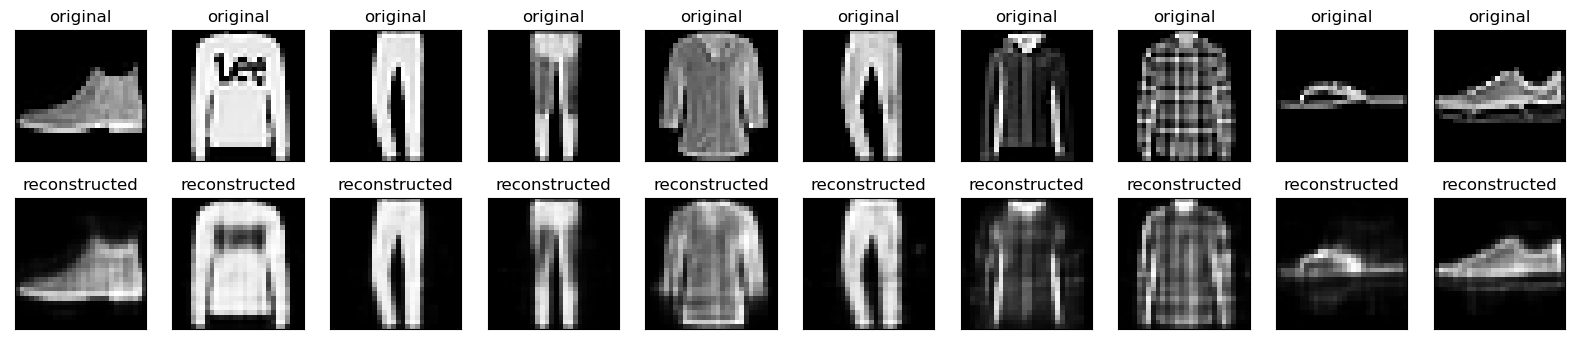

In [5]:
encoded_imgs = auto.encoder(X_test).numpy()
decoded_imgs = auto.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Image Denoising

In [6]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

print(X_train.shape)

(60000, 28, 28, 1)


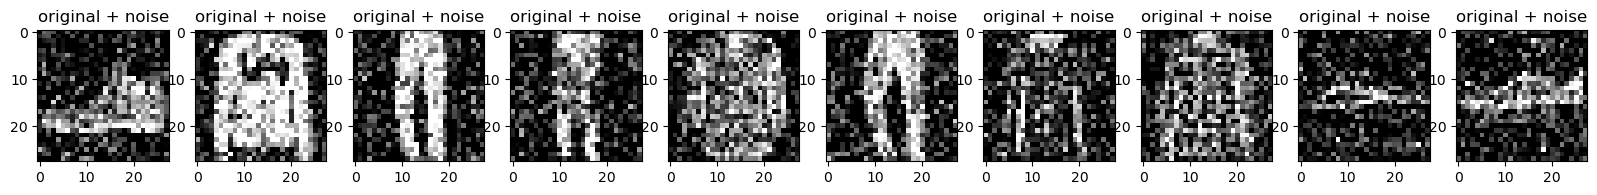

In [7]:
noise_strength = 0.3

X_train_noisy = X_train + noise_strength * tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test + noise_strength * tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
plt.show()

In [8]:
class Conv2DAutoencoder(Model):
  def __init__(self):
    super(Conv2DAutoencoder, self).__init__()
    self.encoder = self.buildEncoder()
    self.decoder = self.buildDecoder()

  def buildEncoder(self):
    return tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
    ])

  def buildDecoder(self):
    return tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
    ])

  def call(self, x):
    return self.decoder(self.encoder(x))

convauto = Conv2DAutoencoder()
convauto.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
convauto.fit(X_train_noisy, X_train, epochs=10, shuffle=True, validation_data=(X_test_noisy, X_test))

Epoch 1/10


2023-01-29 20:51:58.621873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1871/1875 [============================>.] - ETA: 0s - loss: 0.0205

2023-01-29 20:52:09.149631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 5ms/step - loss: 0.0205 - val_loss: 0.0130
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 10/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0106

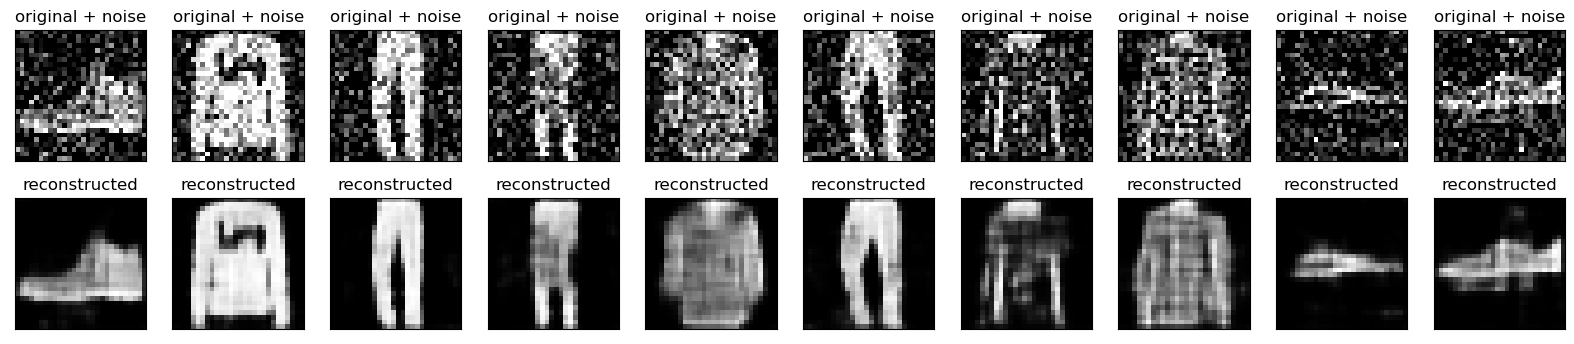

In [10]:
encoded_imgs = convauto.encoder(X_test_noisy).numpy()
decoded_imgs = convauto.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Anomaly Detection

In [2]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
labels = raw_data[:,-1]
data = raw_data[:,0:-1]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalise between [0, 1]

min_val = tf.reduce_min(X_train)
max_val = tf.reduce_max(X_train)

X_train = (X_train - min_val) / (max_val - min_val)
X_test = (X_test - min_val) / (max_val - min_val)

X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

In [4]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_normal = X_train[y_train]
X_test_normal = X_test[y_test]

X_train_anomalous = X_train[~y_train]
X_test_anomalous = X_test[~y_test]

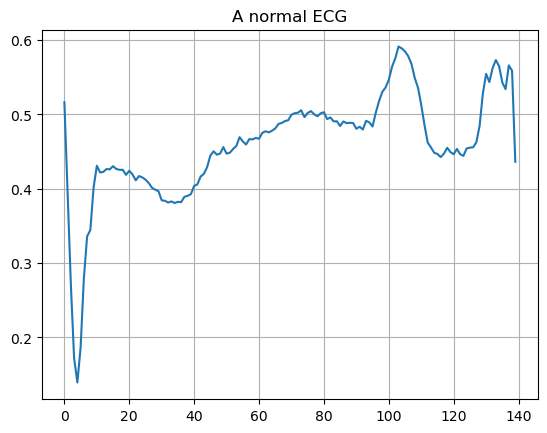

In [5]:
plt.grid()
plt.plot(np.arange(140), X_train_normal[0])
plt.title("A normal ECG")
plt.show()

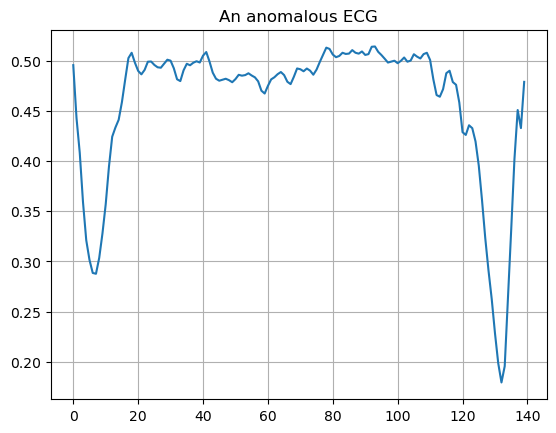

In [6]:
plt.grid()
plt.plot(np.arange(140), X_train_anomalous[0])
plt.title("An anomalous ECG")
plt.show()

In [6]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = self.buildEncoder()
    self.decoder = self.buildDecoder()

  def buildEncoder(self):
    return tf.keras.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
    ])

  def buildDecoder(self):
    return tf.keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(140, activation='sigmoid'),
    ])

  def call(self, x):
    return self.decoder(self.encoder(x))

model = AnomalyDetector()
model.compile(optimizer='adam', loss='mae')

In [7]:
history = model.fit(X_train_normal, X_train_normal,
                    epochs=500, batch_size=512,
                    validation_data=(X_test, X_test),
                    shuffle=True)

Epoch 1/500
1/5 [=====>........................] - ETA: 0s - loss: 0.0592

2023-01-30 20:19:22.913892: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 0s 15ms/step - loss: 0.0582 - val_loss: 0.0537
Epoch 2/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0565 - val_loss: 0.0521
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0541 - val_loss: 0.0503
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0507 - val_loss: 0.0484
Epoch 5/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 6/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0436
Epoch 7/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.0416
Epoch 8/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0398
Epoch 9/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0387
Epoch 10/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0376
Epoch 11/500
5/5 [======================

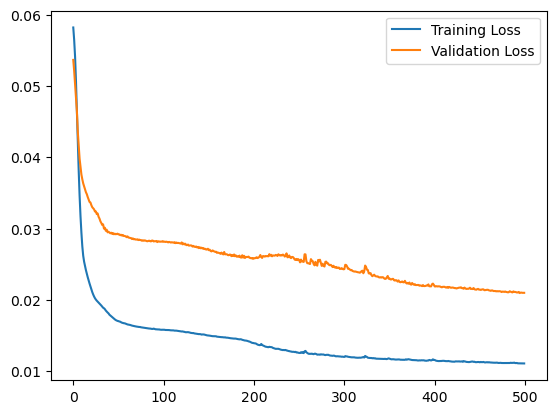

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

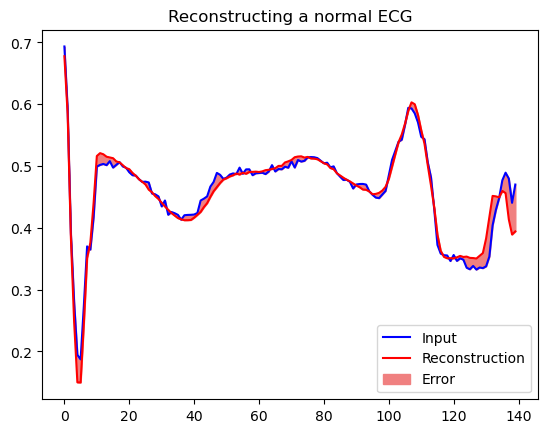

In [19]:
X_test_encoded = model.encoder(X_test_normal).numpy()
X_test_decoded = model.decoder(X_test_encoded).numpy()

plt.plot(X_test_normal[0], 'b')
plt.plot(X_test_decoded[0], 'r')
plt.fill_between(np.arange(140), X_test_decoded[0], X_test_normal[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title("Reconstructing a normal ECG")
plt.show()

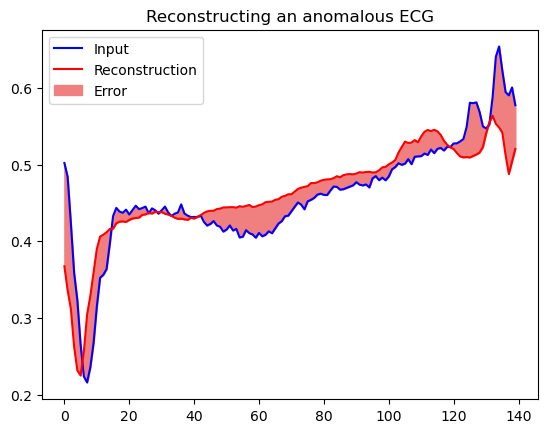

In [20]:
X_test_encoded = model.encoder(X_test_anomalous).numpy()
X_test_decoded = model.decoder(X_test_encoded).numpy()

plt.plot(X_test_anomalous[0], 'b')
plt.plot(X_test_decoded[0], 'r')
plt.fill_between(np.arange(140), X_test_decoded[0], X_test_anomalous[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title("Reconstructing an anomalous ECG")
plt.show()

71/73 [============================>.] - ETA: 0s

2023-01-29 22:34:06.645199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 0s 2ms/step


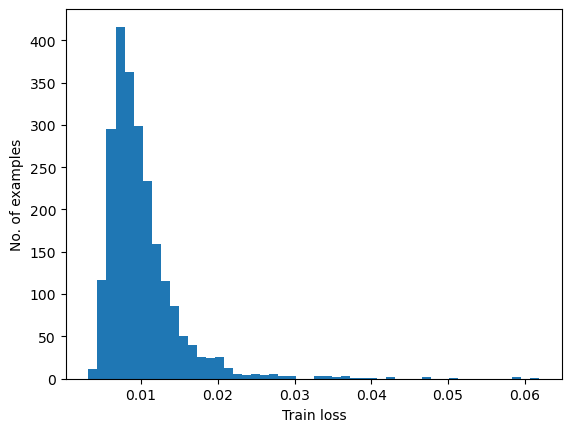

In [21]:
reconstructions = model.predict(X_train_normal)
train_loss = tf.keras.losses.mae(reconstructions, X_train_normal)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No. of examples")
plt.show()

In [22]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(f"Threshold: {threshold}")

Threshold: 0.015036624856293201


13/13 [==============================] - 0s 8ms/step


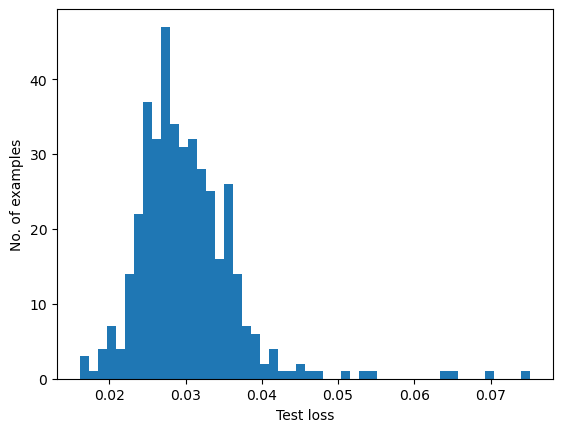

In [23]:
reconstructions = model.predict(X_test_anomalous)
test_loss = tf.keras.losses.mae(reconstructions, X_test_anomalous)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No. of examples")
plt.show()

In [24]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(f"Accuracy = {accuracy_score(labels, predictions)}")
  print(f"Precision = {precision_score(labels, predictions)}")
  print(f"Recall = {recall_score(labels, predictions)}")

preds = predict(model, X_test, threshold)
print_stats(preds, y_test)

Accuracy = 0.933
Precision = 1.0
Recall = 0.8866328257191202
